# Introduction to Data Science（HW1）

In [1]:
import findspark

In [2]:
findspark.init()

In [1]:
import os
os.environ["JAVA_HOME"] = "C:/Java/jdk1.8.0_301"

In [3]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.


In [4]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [5]:
import pyspark
from pyspark import SparkContext as sc
from pyspark import SparkConf
conf=SparkConf().setAppName("miniProject").setMaster("local[*]")
sc=SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [4]:
spark

# Qustion 1：Know More about Vietnam War

**Dataset Information:**

THOR is a painstakingly cultivated database of historic aerial bombings from World War I through Vietnam. THOR has already proven useful in finding unexploded ordnance in Southeast Asia and improving Air Force combat tactics:
https://www.kaggle.com/usaf/vietnam-war-bombing-operations

Load the datasets:

In [6]:
Bombing_Operations = spark.read.json("Bombing_Operations.json.gz")
Aircraft_Glossary = spark.read.json("Aircraft_Glossary.json.gz")

**1.   Select 3 sample (random choose) of Bombing_Operations and save the result as TempTable**

**(10 point)**

In [7]:
# YOUR CODE HERE
Bombing_Operations_Sample = spark.createDataFrame(Bombing_Operations.rdd.takeSample(False,3),schema = Bombing_Operations.schema)
Bombing_Operations_Sample.registerTempTable("Bombing_Operations_Sample")
spark.sql("select * from Bombing_Operations_Sample").show()

+--------+--------------------+-----------+--------------------+-----------+---------------+-------------+------------+--------------+-------------------+
|AirCraft| ContryFlyingMission|MissionDate|  OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|    WeaponType|WeaponsLoadedWeight|
+--------+--------------------+-----------+--------------------+-----------+---------------+-------------+------------+--------------+-------------------+
|   F-100|UNITED STATES OF ...| 1968-10-28|IN COUNTRY - COMB...|          N|      PHAN RANG|SOUTH VIETNAM|      2002.0|750LB GP M-117|                 -1|
|     F-4|UNITED STATES OF ...| 1973-07-26|                null|          N|      NAM PHONG|     THAILAND|      1800.0|          null|                  0|
|     A-4|UNITED STATES OF ...| 1966-11-21|          IN COUNTRY|          D|        CHU LAI|SOUTH VIETNAM|       230.0|       LAU-10A|                 -1|
+--------+--------------------+-----------+--------------------+------


**2. Count the top 5 countries considered to be the most Targetcountry in the Bombing_Operations data set, and count their total TimeOnTarget**

**(10 point)**

In [8]:
# YOUR CODE HERE

target_time_sum = Bombing_Operations.\
    filter(Bombing_Operations.TargetCountry != "UNKNOWN").\
    groupBy("TargetCountry").\
    sum("TimeOnTarget").\
    orderBy('sum(TimeOnTarget)', ascending=False)

target_time_sum.show(5)
target_time_sum_top5 = target_time_sum.head(5)

+-------------+-----------------+
|TargetCountry|sum(TimeOnTarget)|
+-------------+-----------------+
|SOUTH VIETNAM|    1.778017197E9|
|         LAOS|    1.162924419E9|
|NORTH VIETNAM|     6.05604794E8|
|     CAMBODIA|     1.69886781E8|
|     THAILAND|      4.5229813E7|
+-------------+-----------------+
only showing top 5 rows



**3. draw a bar graph of the number of different Aircraft types（y）in different TargetCountry （x）(legend: Aircraft type)**

**（20 point）**

Text(0, 0.5, 'AirCraft Type Count')

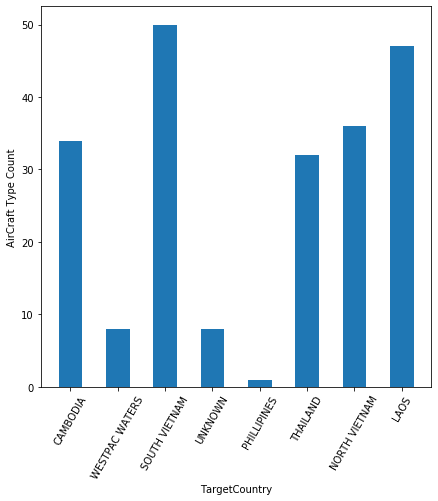

In [9]:
# YOUR CODE HERE

Bombing_Operations_Diff_AT = Bombing_Operations.select(["AirCraft", "TargetCountry"]).distinct()
Bombing_Operations_Diff_AT = Bombing_Operations_Diff_AT.join(Aircraft_Glossary, on='AirCraft', how='left')
Bombing_Operations_Diff_AT = Bombing_Operations_Diff_AT.select(["AirCraftType", "TargetCountry"]).distinct()
PD_Bombing_Operations_Diff_AT = Bombing_Operations_Diff_AT.groupBy("TargetCountry").count().toPandas()
plt.figure(figsize=(7,7))
plt.bar(PD_Bombing_Operations_Diff_AT.TargetCountry, height=PD_Bombing_Operations_Diff_AT["count"], width=0.5)
plt.xticks(rotation=60)
plt.xlabel("TargetCountry")
plt.ylabel("AirCraft Type Count")

Text(0, 0.5, 'AirCraft Type Count')

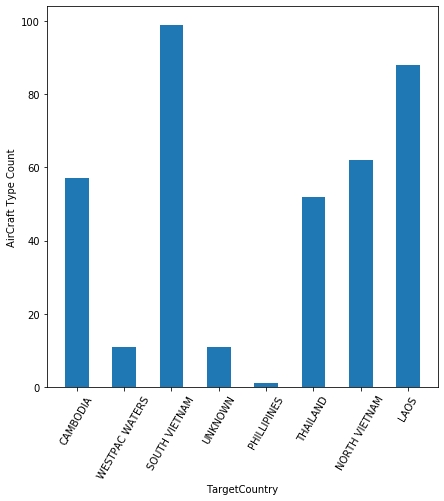

In [10]:
Bombing_Operations_Diff_AT = Bombing_Operations.select(["AirCraft", "TargetCountry"]).distinct()
PD_Bombing_Operations_Diff_AT = Bombing_Operations_Diff_AT.groupBy("TargetCountry").count().toPandas()
plt.figure(figsize=(7,7))
plt.bar(PD_Bombing_Operations_Diff_AT.TargetCountry, height=PD_Bombing_Operations_Diff_AT["count"], width=0.5)
plt.xticks(rotation=60)
plt.xlabel("TargetCountry")
plt.ylabel("AirCraft Type Count")


**4. Use the \<Spark SQL\> to select the weapon whose Aircraft type is'F-105' in Bombing_Operations data**

**(20 point)**

In [11]:
# YOUR CODE HERE
Bombing_Operations_WT = Bombing_Operations.filter(Bombing_Operations.AirCraft=='F-105').select("WeaponType").filter(~(col("WeaponType").isNull()))
Bombing_Operations_WT.show()


+--------------------+
|          WeaponType|
+--------------------+
|MK 82 GP BOMB (50...|
|MK 82 GP BOMB (50...|
|MK 82 GP BOMB (50...|
|MK 82 GP BOMB (50...|
|    AGM-45A SHRIKE-3|
|    AGM-45A SHRIKE-3|
|MK 82 GP BOMB (50...|
|MK 82 GP BOMB (50...|
|    AGM-45A SHRIKE-3|
|    AGM-45A SHRIKE-3|
|AGM-72 STD AR MISSLE|
|AGM-72 STD AR MISSLE|
|MK 82 GP BOMB (50...|
|MK 82 GP BOMB (50...|
|AGM-72 STD AR MISSLE|
| MK84 GP BOMB (2000)|
|AGM-72 STD AR MISSLE|
|AGM-72 STD AR MISSLE|
|    AGM-45A SHRIKE-3|
|MK 82 GP BOMB (50...|
+--------------------+
only showing top 20 rows



**5. Count aircraft  from January to December where Take off Location as'TAN SON NHUT' in Bombing_Operations data, and plot the result.**

**（20 point）**

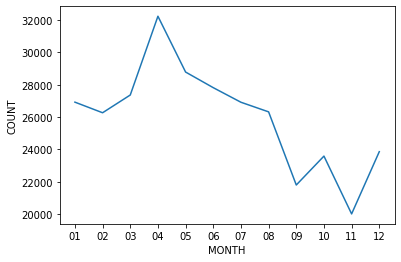

In [12]:
# YOUR CODE HERE

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

@udf(returnType=StringType())
def replace_str(string):
    string = str(string)
    return string[5:7] if len(string) == 10 else "00"

Bombing_Operations_TSN = Bombing_Operations.filter(Bombing_Operations.TakeoffLocation == "TAN SON NHUT")
Bombing_Operations_TSN = Bombing_Operations_TSN.\
    withColumn("MONTH", replace_str(Bombing_Operations_TSN["MissionDate"])).select("MONTH")
# Bombing_Operations_TSN.show()
Bombing_Operations_TSN = Bombing_Operations_TSN.groupBy("MONTH").count()
pd_Bombing_Operations_TSN = Bombing_Operations_TSN.toPandas()
pd_Bombing_Operations_TSN = pd_Bombing_Operations_TSN.sort_values("MONTH")
plt.plot(pd_Bombing_Operations_TSN.MONTH, pd_Bombing_Operations_TSN["count"])
plt.xlabel("MONTH")
plt.ylabel("COUNT")
plt.show()

**6. Please select the aircraft whose WeaponType is None and groupby each Target country**

**（10 point）**

In [25]:
# YOUR CODE HERE
Bombing_Operations_WeaponType_Null = Bombing_Operations.filter(col("WeaponType").isNull()).select(["AirCraft", "TargetCountry"])

# Bombing_Operations_WeaponType_Null.show()
Bombing_Operations_WeaponType_Null.groupby("TargetCountry").agg(collect_list('AirCraft').alias('AirCraftList')).show()

+--------------+--------------------+
| TargetCountry|        AirCraftList|
+--------------+--------------------+
|      CAMBODIA|[EC-47, AU-24, AC...|
|WESTPAC WATERS|[EC-121, A-6, A-4...|
| SOUTH VIETNAM|[EC-47, A-37, EC-...|
|       UNKNOWN|[A-4, F-4, F-105,...|
|   PHILLIPINES|              [RF-8]|
|      THAILAND|[CH-53, CH-53, F-...|
| NORTH VIETNAM|[A-7, A-6, A-7, A...|
|          LAOS|[RF-4, A-4, F-4, ...|
+--------------+--------------------+



# Question 2：Instacart Market Basket Analysis（10 point）

The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. For more information, see the blog post accompanying its public release.

https://www.kaggle.com/c/instacart-market-basket-analysis/data

**YOUR TASK**

Use the Spark Dataframe API to join 'products' and 'orders', so that you will be able to see the product names in each transaction (and not only their ids). Then, group by the orders by 'order_id' to obtain one row per basket (i.e., set of products purchased together by one customer).

In [13]:
products = spark.read.csv('products.csv', header=True, inferSchema=True)
orders = spark.read.csv('order_products__train.csv', header=True, inferSchema=True)

In [14]:
# YOUR CODE HERE
order_with_prodcutid = orders.join(products, on='product_id', how='left')
product_list_per_order = order_with_prodcutid.groupby("order_id").agg(collect_list('product_name').alias('product_nameList'))
product_list_per_order.show()

+--------+--------------------+
|order_id|    product_nameList|
+--------+--------------------+
|    1342|[Bag of Organic B...|
|    1591|[Cracked Wheat, O...|
|    4519|[Beet Apple Carro...|
|    4935|             [Vodka]|
|    6357|[Fresh Mozzarella...|
|   10362|[Crinkle Cut Fren...|
|   19204|[Lemon Lime Thirs...|
|   29601|[Toasted Coconut ...|
|   31035|[Bag of Organic B...|
|   40011|[Sea Salt Macadam...|
|   46266|[Organic Uncured ...|
|   51607|[Major Dickason's...|
|   58797|[Bag of Organic B...|
|   61793|[Raspberries, Nat...|
|   67089|[Banana, Organic ...|
|   70863|[Bathroom Tissue,...|
|   88674|[Unsweetened Almo...|
|   91937|[No. 485 Gin, Tra...|
|   92317|[Banana, Indian M...|
|   99621|[Organic Basil, F...|
+--------+--------------------+
only showing top 20 rows

